# Maximum Likelihood Functions: Workshop (part 2)

## Application on Luminosity Functions

Studying the dependence of the number of objects in a survey on the luminosity or flux or photon counts is a powerful tool in Astrophysics. One of the most universal and commonly used form of the _luminosity function_ (LF) is the power law:

$$N(>L) = K L^{-a}$$

where $K$ is a normalization factor and $a$ is the slope.

The LFs are actually _luminosity distributions_. Be warned that the above expression __cannot__ describe a probability distribution with support the full range of luminosities: $\left[0, \infty\right)$. It is mathematically necessary to introduce a lower bound: $L_\min$. We can also use an upper bound (if imposed by the theory or data) but we will not consider this case here.

Our distribution's function (CDF) is therefore

$$
F(L) = \begin{cases}
            1 - \left(\frac{L}{L_\min}\right)^{-a} & \text{ for } L \geq L_\min \\
            0 & \text{ for } L < L_\min
       \end{cases}
$$

### Generating a sample

The `scipy.stats` package defines a power law distribution defined in the range $\left[0, \, 1\right]$ and for positive exponent --- not the one we are interested it. We can create our own sampler by employing the __inverse transfrom method__ (for more, _Luc Devroye (1998). Non-Uniform Random Variate Generation_: http://www.eirene.de/Devroye.pdf) that depends only on the knowledge of the inverse CDF:

> Let $F_X(x)$ be a cumulative distribution function and $Y$ a conntinuous random variable $\sim \mathcal{U}\left[0, 1\right]$, then $X = F^{-1}\left(Y\right)$ is distributed as $F_X$

Consequently, if $\mathbf{X}$ is a sample from standard uniform distribution, then

$$\mathbf{L} = L_\min \left(\mathbf{I} - \mathbf{X}\right)^{-\frac{1}{a}}$$

is a power law distributed sample with lower bound.

### Explanation of the code

The following code demonstrates the above. We have wrote down some help pieces of code:

* The class `PowerLawDist` can be used to get the CDF (method `.cdf(x)`) or a sample (method `.rvs(size)`) from the power law distribution with the desired parameters
* The function `log_edges(sample, n)` reads finds the minimum (ignoring zeros) and maximum in the sample, and creates `n` values spanning the full range. These values are evenly spaced in log-scale (geometric series). This way we can plot the LF as it is found in the literature: log-scale for both axes.
* The function `plot_luminosity_function(sample, bins, **args)` plots the reversed cumulative histogram of the sample defined by the given `bins`. Extra arguments for matplotlib.pyplot.hist (e.g. color) can be added at the end (`args`).

In the plot we confirm that the sampling technique and the analytical formula agree.

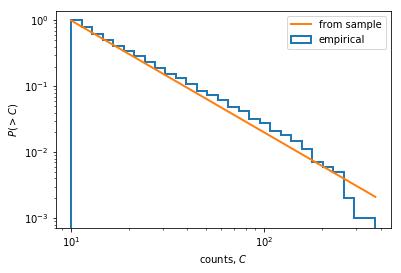

In [7]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


## Helper class and functions

class PowerLawDist:
    # this class represents the power law distribution with CDF: 1 - (x / minimum) ^ -slope
    def __init__(self, minimum, slope):
        # initializes an object with fixed parameters
        self.minimum = minimum
        self.slope = slope
    
    def rvs(self, size):
        # draws 'size' values from the distribution (using inverse transformation sampling)
        return self.minimum * (1.0 - st.uniform.rvs(size = size)) ** (-1.0 / self.slope)
    
    def cdf(self, x):
        # returns the CDF evaluated at 'x' (single number, or numpy array)
        return 1.0 - (x / self.minimum) ** (-self.slope)    
    
def log_edges(data, n):
    # returns the geometric series of 'n' terms, to cover the full extend of 'data'
    min_in_data = min(data[data > 0.0]) # ignore zeros when getting the minimum value (avoiding -inf)
    max_in_data = max(data)
    return np.exp(np.linspace(np.log(min_in_data), np.log(max_in_data), n))

def plot_luminosity_function(sample, bins, **arguments_for_hist):
    # plots a reversed cumulative histogram
    plt.hist(sample, bins = bins, cumulative = -1, histtype = "step", **arguments_for_hist)
    

## Sample from power-law and compute the analytical formula
Lmin = 10.0
a = 1.7
N = 1000 # number of sources
dist = PowerLawDist(Lmin, a)
sample = dist.rvs(size = N)
x = log_edges(sample, 30) # compute bin edges
y = 1.0 - dist.cdf(x) # analytical P(>L)

## Plot
plot_luminosity_function(sample, bins = x, normed = True, label = "empirical", linewidth = 2)
plt.plot(x, y, label = "from sample", linewidth = 2) # plot the analytical 1-CDF(x)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("counts, $C$")
plt.ylabel("$P(>C)$")
plt.legend()
plt.show()

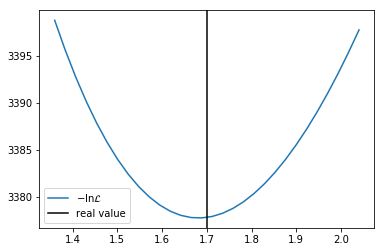

In [8]:
def P(L, minimum, slope):
    return slope / minimum * (L / minimum) ** (-slope - 1.0)

def neg_lnL(data, minimum, slope):
    return -np.sum(np.log(P(data, minimum, slope)))

trialslopes = np.linspace(a * 0.8, a * 1.2, 30)
likelihoods = np.array([neg_lnL(sample, Lmin, slope) for slope in trialslopes])

plt.plot(trialslopes, likelihoods, label = r"$-\ln{\mathcal{L}}$")
plt.axvline(a, color = "k", label = r"real value")
plt.legend()
plt.show()

## Analytical solution?

It is possible to derive the analytical solution for this likelihood function too. Though, introducing a more complicated model (Poisson distribution for counts, background, confusion limit, etc.) will create a complicated formula that not only cannot be solved analytically but also can be computationally challenging (numerical overflows when computing factorials, gamma functions etc. / approximations / computational efficiency / multiple minima)

# Relation to $\chi^2$

In the least squares method (LSM) we fit the data, e.g. $(x_i, y_i)$ with uncertainties $\sigma_i$ to a curve (our model) $y = y(x)$. Thus, the parameters of the curve are estimated by minimizing the quantity

$$ \chi^2 = \sum_i\left[\frac{y_i - y(x_i)}{\sigma_i}\right]^2 $$

__But how this formula is justified?__

Assuming Gaussian distribution of the uncertainties, the probability to measure $y_i$ with standard deviation $\sigma_i$ about the "actual" value $y(x_i)$ is

$$ P_i = \frac{1}{\sigma\sqrt{2\pi}} \exp\left\{-\frac{1}{2}\left[ \frac{y_i - y(x_i)}{\sigma_i} \right]^2\right\} $$

Working as before,

$$ -\ln{\mathcal{L}} = -\sum_i \ln P_i = \sum_i \ln{\sigma_i \sqrt{2\pi}} + \frac{1}{2} \sum_i\left[\frac{y_i - y(x_i)}{\sigma_i}\right]^2$$

Then, minimizing we get:

$$ \frac{\mathrm{d}}{\mathrm{d}\mathcal{L}} \left(-\ln \mathcal{L}\right)  = 0 $$
$$ \frac{\mathrm{d}}{\mathrm{d}\mathcal{L}} \sum_i\left[\frac{y_i - y(x_i)}{\sigma_i}\right]^2 = 0 $$
$$ \frac{\mathrm{d} \chi^2}{\mathrm{d}\mathcal{L}} = 0 $$

So the quantity $\chi^2$ is defined as the quantity that when minimized, the likelihood is maximized.

### In terms of uncertainties...

We can estimate the uncertainty of each parameter by defining the region where 

> $\ln\mathcal{L}$ changes by $\frac{1}{2}$

or equivalently

> $\mathcal{L}$ changes by $e^{\frac{1}{2}}$

or equivalently

> $\chi^2$ increases by $1$!